## Binance
#### the World's largest cryptocurrency exchange by trading volume


## Upbit
#### the largest cryptocurrency exchange in South Korea

# Data Crawling

In [8]:
import requests
import pandas as pd
import time
import numpy as np

# For Binance

def get_binance_ohlcv(symbol="BTCUSDT", interval="1d", start="2024-06-30", end="2026-02-18"):
    url = "https://fapi.binance.com/fapi/v1/klines"
    start_ms = int(pd.Timestamp(start).timestamp() * 1000)
    end_ms   = int(pd.Timestamp(end).timestamp() * 1000)
    
    all_data = []
    while start_ms < end_ms:
        params = {"symbol": symbol, "interval": interval,
                  "startTime": start_ms, "endTime": end_ms, "limit": 1000}
        resp = requests.get(url, params=params).json()
        if not resp:
            break
        all_data.extend(resp)
        start_ms = resp[-1][0] + 1  # move to next timestamp for next candle

    df = pd.DataFrame(all_data, columns=[
        "open_time","open","high","low","close","volume",
        "close_time","quote_volume","trades",
        "taker_buy_base","taker_buy_quote","ignore"
    ])
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
    df[["open","high","low","close","volume"]] = df[["open","high","low","close","volume"]].astype(float)
    return df

# For Upbit

def get_upbit_ohlcv(market="KRW-BTC", start="2024-06-30", end="2026-02-19"):
    url = "https://api.upbit.com/v1/candles/days"
    end_dt = pd.Timestamp(end)
    start_dt = pd.Timestamp(start)
    
    all_data = []
    cursor = end_dt

    while cursor > start_dt:
        params = {"market": market, "count": 200, "to": cursor.strftime("%Y-%m-%dT%H:%M:%SZ")} # maximum 200 candles per request
        resp = requests.get(url, params=params).json()
        if not resp:
            break
        all_data.extend(resp)
        cursor = pd.Timestamp(resp[-1]["candle_date_time_utc"]) - pd.Timedelta(days=1)
        time.sleep(0.1)  # for rate limits

    df = pd.DataFrame(all_data)
    df["candle_date_time_utc"] = pd.to_datetime(df["candle_date_time_utc"])
    df = df[df["candle_date_time_utc"] >= start_dt].sort_values("candle_date_time_utc")
    return df


def get_exchange_rate(market="KRW-USDT", start="2024-06-30", end="2026-02-19"):
    df = get_upbit_ohlcv(market=market, start=start, end=end)
    return df

bi_df = get_binance_ohlcv()
up_df = get_upbit_ohlcv()
rate_df = get_exchange_rate()

# Data Cleaning

In [9]:
bi_df["date"] =  bi_df["open_time"].dt.date
up_df["date"] = up_df["candle_date_time_utc"].dt.date
rate_df["date"] = rate_df["candle_date_time_utc"].dt.date

# print("Binance DataFrame Length:", len(bi_df), "\nUpbit DataFrame Length:", len(up_df))

bi_dates = set(bi_df["date"])
up_dates = set(up_df["date"])
rate_dates = set(rate_df["date"])

# print(sorted(up_dates- rate_dates))
# print(sorted(rate_dates - up_dates))
# print(sorted(bi_dates - up_dates))



bi_df = bi_df.rename(columns={"close": "binance_close"})
up_df = up_df.rename(columns={"trade_price": "upbit_close"})
rate_df = rate_df.rename(columns={"trade_price": "krw_usdt_rate"})

bi_df = bi_df.drop(columns=["open_time","open","high","low","volume","close_time","quote_volume","trades","taker_buy_base","taker_buy_quote","ignore"])
up_df = up_df.drop(columns=["candle_date_time_utc","candle_date_time_kst","opening_price","high_price","low_price","timestamp",'candle_acc_trade_volume',
       'prev_closing_price', 'change_price',"change_rate",'market','candle_acc_trade_price'])
rate_df = rate_df.drop(columns=["candle_date_time_utc","candle_date_time_kst","opening_price","high_price","low_price","timestamp",'market','candle_acc_trade_volume', 'prev_closing_price', 'change_price',
       'change_rate','candle_acc_trade_price'])


# print(bi_df.keys())
# print(up_df.keys())
# print(rate_df.keys())



merged_df = pd.merge(bi_df,up_df, left_on="date", right_on="date", how="inner", suffixes=("_binance", "_upbit"))
merged_df = pd.merge(merged_df, rate_df[["date", "krw_usdt_rate"]], on="date", how="inner")
# print("Merged DataFrame Length:", len(merged_df))
# print(up_df.keys())
# print(bi_df.keys())

merged_df = merged_df[["date", "binance_close", "upbit_close", "krw_usdt_rate"]]
print(merged_df.head()) 

         date  binance_close  upbit_close  krw_usdt_rate
0  2024-06-30        62766.0   87920000.0         1402.0
1  2024-07-01        62883.6   88253000.0         1405.0
2  2024-07-02        62123.6   87248000.0         1406.0
3  2024-07-03        60208.0   85331000.0         1418.0
4  2024-07-04        57045.9   81680000.0         1432.0


# Data Preprocessing

In [10]:
merged_df["upbit_ret"] = merged_df["upbit_close"].pct_change()
merged_df["upbit_close_usd"] = merged_df["upbit_close"] / merged_df["krw_usdt_rate"]

merged_df = merged_df.dropna()


# Data Split

In [11]:
split_date = int(len(merged_df) * 0.5)
back_df = merged_df.iloc[:split_date]  
forward_df = merged_df.iloc[split_date:]
# print(back_df["date"].max())
# print(forward_df["date"].min())

# Backtesting

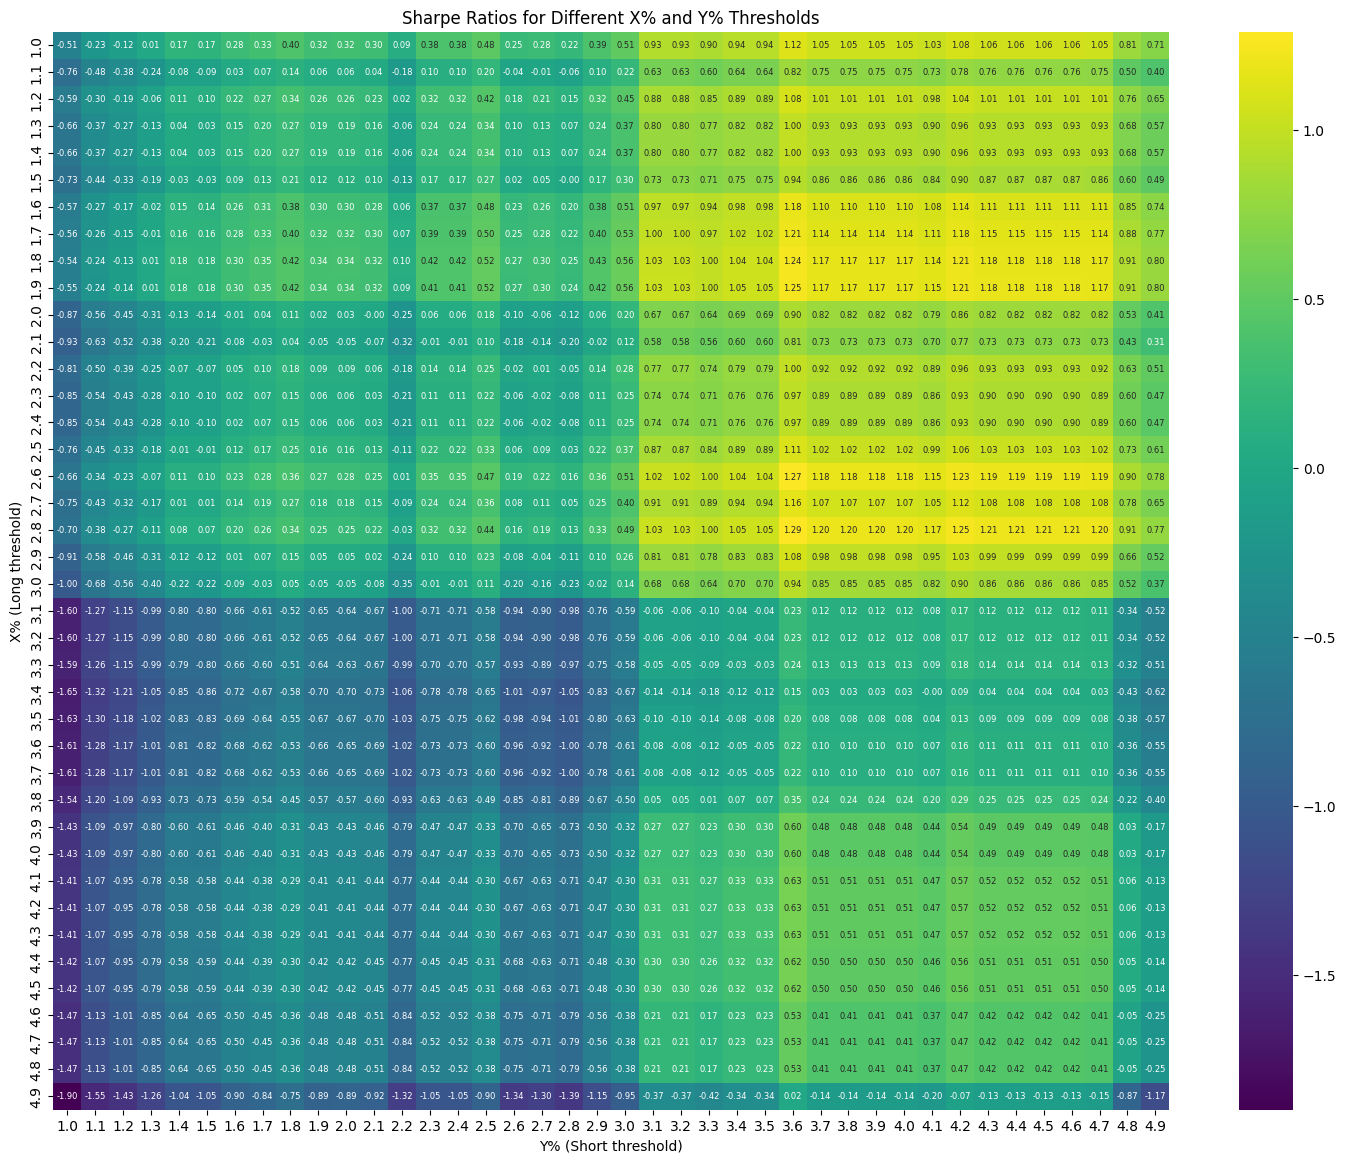

In [12]:
def run_backtest(df, x_pct, y_pct):
    signal = pd.Series(0, index=df.index)
    signal[df["upbit_ret"] >= x_pct/100] = 1
    signal[df["upbit_ret"] <= -y_pct/100] = -1

    binance_returns = df["binance_close"].pct_change().shift(-1)
    
    returns = signal * binance_returns
    return returns.dropna()


x_range = np.arange(1, 5, 0.1)
y_range = np.arange(1, 5, 0.1)

sharpe_ratios = np.zeros((len(x_range), len(y_range)))


for i, x in enumerate(x_range):
    for j, y in enumerate(y_range):
        backtest_returns = run_backtest(back_df, x, y)
        if backtest_returns.std() == 0 or len(backtest_returns) < 10:
            sharpe_ratios[i, j] = 0
        else:
            sharpe_ratios[i, j] = backtest_returns.mean() / backtest_returns.std() * np.sqrt(365)

        
        
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 14))
sns.heatmap(sharpe_ratios, annot=True, fmt=".2f", annot_kws={"size": 6}, cmap="viridis", xticklabels=np.round(y_range, 1), yticklabels=np.round(x_range, 1))
plt.xlabel("Y% (Short threshold)")
plt.ylabel("X% (Long threshold)")
plt.title("Sharpe Ratios for Different X% and Y% Thresholds")
plt.show()

In [13]:
# Best X & Y Combination

best_idx = np.unravel_index(sharpe_ratios.argmax(), sharpe_ratios.shape) # turn the flat index back to 2D index
best_x = x_range[best_idx[0]]
best_y = y_range[best_idx[1]]
print(f"Best X: {best_x:.1f}%, Best Y: {best_y:.1f}%, Sharpe: {sharpe_ratios[best_idx]:.2f}")

Best X: 2.8%, Best Y: 3.6%, Sharpe: 1.29


# Forward Test

In [14]:
forward_returns = run_backtest(forward_df, best_x, best_y)

# Sharpe
forward_sharpe = forward_returns.mean() / forward_returns.std() * np.sqrt(365)
print(f"Forward Test Sharpe Ratio: {forward_sharpe:.2f}")


# Maximum Drawdown
cumulative_returns = (1 + forward_returns).cumprod()
max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()
print(f"Forward Test Max Drawdown: {max_drawdown:.2f}")


# Compound Annual Growth Rate
total_return = cumulative_returns.iloc[-1]
days = len(forward_returns)
forward_cagr = total_return ** (365 / days) - 1
print(f"Forward Test CAGR: {forward_cagr:.2f}")

Forward Test Sharpe Ratio: -0.61
Forward Test Max Drawdown: -0.14
Forward Test CAGR: -0.12
